In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

%load_ext autoreload
%autoreload 2


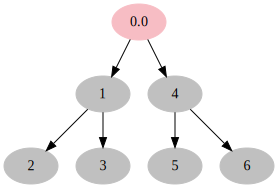

In [2]:
from distributions import Categorical
from mouselab import MouselabEnv
env = MouselabEnv(height=2, reward=Categorical([-1, 1]), cost=0.1)
env.render()

# Define features

In [4]:
# from toolz.curried import *
# # max_paths = len(click_features(env.init, 1)) / 3
# max_paths = 2

# @curry
# def path_features(state, path):
#     val = env.node_value_to(path[-1], state=state)
#     return [val.mean, val.var, val.mean * val.var]

# def click_features(state, click):
#     x = np.zeros(6)
#     pfs = sorted(map(path_features(state), env.all_paths(start=click)))
#     while len(pfs) < max_paths:
#         pfs.append([0, 0, 0])
#     return np.concatenate(pfs)

# Regress to optimal policy

In [15]:
from exact import solve, hash_tree
Q, V, pi, info = solve(env)
V(env.init)

0.8999999999999999

In [5]:
from toolz import memoize
   
def regression_data():
    """Returns features and Q* for all(*) state-action pairs in an env.
    
    (*) the state space is reduced by treating symmetric states as one.
    """
#     Q, V, pi, info = solve(env)
    data = []
    @memoize(key=lambda args, kwargs: hash_tree(env, args[0]))
    def rec(s):
        for a in env.actions(s):
            if a == env.term_action: continue
            for p, s1, r in env.results(s, a):
                data.append({
                    'features': click_features(s, a),
                    'state': s,
                    'action': a,
                    'q_star': Q(s, a)
                })
                rec(s1)
    rec(env.init)
    return pd.DataFrame(data)

df = regression_data()

In [6]:
from sklearn.linear_model import LinearRegression
X = np.stack(df.features)
model = LinearRegression().fit(X, df.q_star)

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


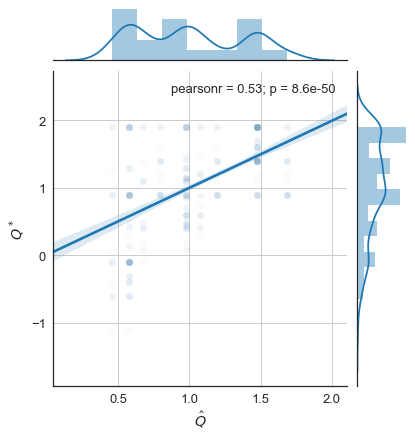

In [7]:
sns.jointplot(model.predict(X), df.q_star, kind='reg',
              joint_kws=dict(scatter_kws=dict(alpha=0.01)))
plt.grid()
plt.ylabel(r'$Q^*$')
plt.xlabel(r'$\hat{Q}$')

# Learn a max-Q policy

In [245]:
from agents import Agent
from evaluation import get_util
from human_model import HumanPolicy
from policies import RandomPolicy, FixedPlanPolicy, LiederPolicy

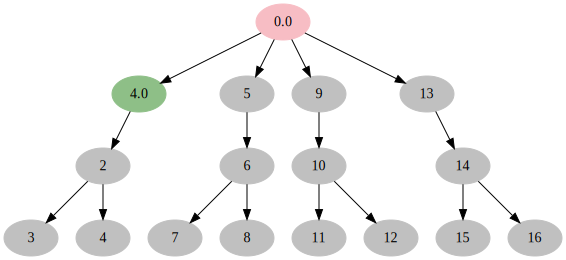

In [254]:
env.render()

[  0.     35.344  35.344  18.172  18.172  35.344  35.344  18.172  18.172  35.344  35.344  18.172  18.172  35.344  35.344  18.172  18.172   0.   ]


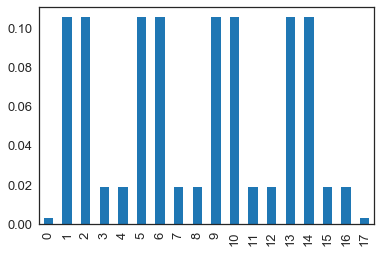

In [257]:
from human_model import HumanPolicy
agent = Agent()
theta = np.ones(8)
theta[0] = 1
pol = HumanPolicy(theta, 10)
agent.register(env)
agent.register(pol)
pd.Series(pol.action_distribution(env._state)).plot.bar()

In [259]:
pol = HumanPolicy.optimize([env] * 100, n_calls=30)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [7]:
from model_utils import make_env

def get_human(cost):
    env = make_env(cost)
    return HumanPolicy.optimize([env] * 200, n_calls=50)

COSTS = np.logspace(-10, 0, 11, base=2)
from joblib import delayed, Parallel
results = Parallel(11)(delayed(get_human)(cost) for cost in COSTS)
human = dict(zip(COSTS, results))

/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point 

BO: [-2.214  9.854 -2.871 -1.246  4.113 -9.931 -2.38 ] -> 0.0 in 142 sec
BO: [-2.214  9.854 -2.871 -1.246  4.113 -9.931 -2.38 ] -> 0.0 in 142 sec
BO: [-10.    -10.      1.55   10.      5.481   3.757  -3.195] -> 0.168 in 153 sec


/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point 

BO: [ 10.  10.  10. -10.  10.  10.  10.] -> 0.945 in 192 sec
BO: [  3.137 -10.     10.     10.     10.    -10.     10.   ] -> 1.106 in 195 sec
BO: [-10.      7.677   5.266 -10.     -2.3   -10.     10.   ] -> 0.659 in 204 sec
BO: [ 10.     10.      6.322  10.     10.     -7.904  10.   ] -> 1.275 in 205 sec
BO: [ 10.  10.  10. -10. -10.  10.  10.] -> 1.277 in 207 sec
BO: [ 10.     10.      7.997  10.     10.    -10.      9.983] -> 1.156 in 209 sec
BO: [ 10.    -10.      4.833  10.     10.    -10.    -10.   ] -> 1.288 in 212 sec
BO: [ 10.     10.      5.262 -10.     10.     -9.503  10.   ] -> 1.27 in 212 sec


In [261]:
envs = pd.read_pickle('data/experimental_envs.pkl')

In [265]:
envs[0.1][0].ground_truth

array([  0.,  12.,   4.,  -4.,  12.,  12.,  12., -12.,  -4., -20.,  -4.,  -4.,  12.,  12.,  -4., -12., -12.])

In [11]:
from evaluation import get_util, evaluate_many
from human_model import HumanPolicy
from policies import FixedPlanPolicy, LiederPolicy

def data(cost):
    env = MouselabEnv(height=2, cost=cost, reward=Categorical([-1, 1]))
    agent = Agent()
    agent.register(env)
    policies = {
        'human': human[cost],
        'random': RandomPolicy(),
        'full-observation': FixedPlanPolicy(range(1, env.term_action+1)),
        'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
    }
    df = evaluate_many(policies, [env] * 2000)
    df['']
    df['cost'] = cost

jobs = (delayed(data)(c) for c in COSTS)
df = pd.concat(Parallel(11)(jobs))

In [34]:
# from exact import solve
# def optimal_util(cost):
#     env = MouselabEnv(height=2, cost=cost, reward=Categorical([-1, 1]))
#     Q, V, pi, info = solve(env)
#     return V(env.init)

# dd = pd.DataFrame({
#         'cost': COSTS,
#         'agent': 'optimal'
#     })
# dd['util'] = dd.cost.apply(optimal_util)
# df = pd.concat([df_, dd])

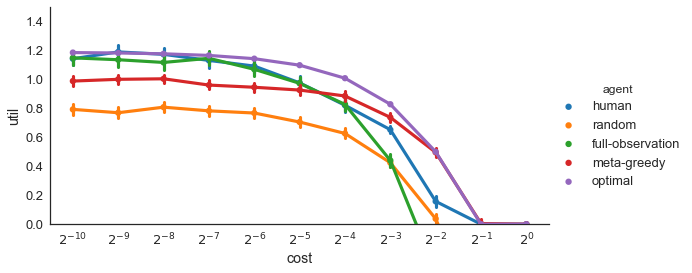

In [53]:
g = sns.factorplot('cost', 'util', hue='agent', data=df, markers='.',
                aspect=2)
plt.ylim(0, 1.5)
g.set_xticklabels([f'$2^{{{i}}}$' for i in range(-10, 1)])

# Fit human data

In [174]:
from analysis_utils import load
from model_utils import *
from toolz import *
from human_model import action_features

df, pdf = load('1.8')
label = Labeler()
def expand():
    for i, row in df.iterrows():
        for s, a in zip(row.states, concatv(row.clicks, [ENV.term_action])):
            yield {'pid': row.pidx, 'cost': row.info_cost, 'pr_type': row.pr_type,
                   'state': label(parse_state(s)), 'action': a}

data = pd.DataFrame(expand())
data.head()

,action,cost,pid,pr_type,state
0,1,1.25,0,none,0
1,17,1.25,0,none,1
2,5,1.25,0,none,0
3,9,1.25,0,none,2
4,1,1.25,0,none,3


Likelihood:
$$p(D \mid \theta) = \prod_i^N p(a_i \mid s_i; \theta)$$

Softmax Q policy:
$$p(a \mid s; \theta) = \frac{\exp \{ Q(s, a; \theta) \} }{ \sum_{a'} \exp \{ Q(s, a'; \theta) \} }$$

Linear regression Q:
$$Q(s, a; \theta) = \theta^\top \phi(s, a)$$

Before performing inference, we precompute the features, storing them in a 3d tensor.
`phi[s, a, f]` will give the value $\phi(s, a)_f$


In [175]:
data = data.query('pid == 0')

In [176]:
phi = np.array([[action_features(env, s, a) for a in range(env.term_action + 1)]
                 for s in label._xs])


In [191]:
# data.iloc[Q.argmin()]

IndexError: single positional indexer is out-of-bounds

In [194]:
len(Q)

61

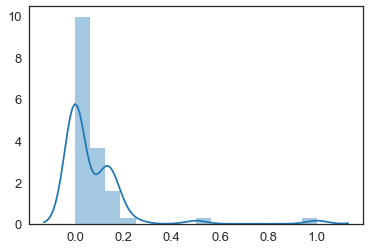

In [209]:
import pymc3 as pm
import theano.tensor as tt

n_pid = data.pid.max() + 1
n_feature = len(phi[0,0])
idx = np.arange(len(data))

with pm.Model() as model:
    
    theta = pm.Normal('theta', 0, 10, shape=n_feature)
    Q = tt.dot(phi[data.state.as_matrix()], theta)
    eq = tt.exp(Q)
    chosen = eq[idx, data.action.as_matrix()]
    pm.Potential('logp', np.log(chosen / (eq.sum(1) + 1e-10)).sum())
    
    trace = pm.sample()
    
    

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
[2017-12-16 15:56:27,750] install mkl with `conda install mkl-service`: No module named 'mkl'
100%|██████████| 1000/1000 [00:54<00:00, 16.81it/s]/usr/local/lib/miniconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.679024775983, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



In [214]:
trace['theta'].mean(0)

array([ 0.542,  0.56 ,  0.658, -0.01 , -0.014, -8.584,  0.075,  0.587])